# Imports

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img,img_to_array,load_img
from PIL import Image 

2022-09-27 01:07:13.675984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set the necessary directories
!pwd
img_dir = './inputs/Images/'

img_filenames = os.listdir(img_dir)
img_names = [s.split('.')[0] for s in img_filenames]

img_ext = '.jpg'

/Users/sukeng/Desktop/ML_projects/Kaggle  Sea-Ice


# Defining Masks

Masks are encoded in SIGRID-3 format. See here for more information: https://library.wmo.int/doc_num.php?explnum_id=9270

We will map the ice concentratoin codes according to the following library to simplify the classes

In [3]:
mask_lib = {55:0, #ice free
            1:0, #<1/10 (open water)
            2:0, #bergy water
            10:1, #1/10
            12:1, #1/10-2/10
            13:1, #1/10-3/10
            20:1, #2/20
            23:1, #2/20-3/10
            24:2, #2/20-4/10
            30:2, #...
            34:2,
            35:2,
            40:2,
            45:2,
            46:3,
            50:3,
            56:3,
            57:3,
            60:3,
            67:3,
            68:4, #...
            70:4, #7/10
            78:4, #7/10-8/10
            79:4, #7/10-9/10
            80:4, #8/10
            89:4, #8/10-9/10
            81:5, #8/10-10/10
            90:5, #9/10
            91:5, #9/10-10/10
            92:6, #10/10 - fast ice
            100:7, #land
            99:7, #unknown - there is nothing in this class for this dataset
           }

#define a colormap for the mask
n_colors=8
ice_colors = n_colors-1
jet = plt.get_cmap('jet', ice_colors)
newcolors = jet(np.linspace(0, 1, ice_colors))
black = np.array([[0, 0, 0, 1]])
white = np.array([[1, 1, 1, 1]])
newcolors = np.concatenate((newcolors, black), axis=0) #land will be black
cmap = ListedColormap(newcolors)

In [6]:
np.linspace(0, 1, ice_colors)


array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

Run through and convert all masks from SIGRID-3 to simplified. Also store the pixel class counts for each mask in a dataframe.

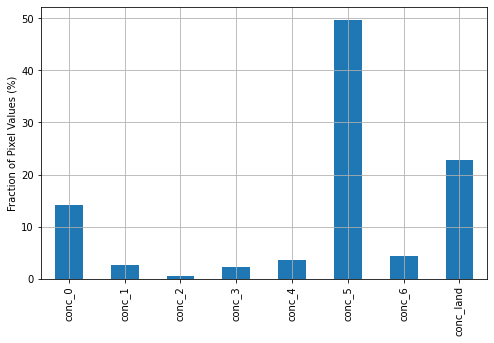

In [7]:
#function to map mask values according to above library
def map_mask(mask, lib):
    new_mask = mask.copy()
    for key, val in lib.items():#map the elements of the array to their new values according to the library
        new_mask[mask==key]=val
    return new_mask

#function to calculate the value counts over all pixels in an image (fed in as a numpy array)
def bincount_2d(arr, max_int):
    counts_full = [0 for n in range(max_int)]
    for row in arr:
        counts = np.bincount(row).tolist()#get the counts for the row
        pad = [0 for n in range(max_int-len(counts))]
        counts = counts + pad #add extra zeroes to account for colors above the max in the row
        counts_full = [counts_full[n] + counts[n] for n in range(max_int)]
    return(counts_full)

# convert all mask files from SIGRID 3 format to simplified
mask_dir = './inputs/Masks/'
mask_ext = '-mask.png'
new_mask_ext = '-mask-mod.png'
dat = []#list that will hold information on the masks

for img_name in img_names:
    name = mask_dir + img_name
    # importing the image  
    mask = Image.open(name + mask_ext)

    # converting mask
    mask = np.array(mask)#convert to numpy
    new_mask = map_mask(mask, mask_lib)#map values
    
    #update dataframe
    name = img_name.split('-')  
    d = [img_name, 
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour
    
    counts = bincount_2d(new_mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat.append(d)
    
    # exporting the image 
    new_mask = Image.fromarray(new_mask)#convert back to image
    new_mask.save('./' + img_name + new_mask_ext, 'PNG') 

mask_dir = './'#update mask directory and extension
mask_ext= new_mask_ext

#create dataframe of mask information
mask_df = pd.DataFrame(dat, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour', 
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',  
                            'conc_land'])

#plot realtive frequency of ice concentrations in images
counts = mask_df.iloc[:,6:].sum()
norm = counts.sum()
probs = counts/norm*100

plt.figure(figsize=(8,5))
probs.plot(kind='bar')
plt.ylabel('Fraction of Pixel Values (%)')
plt.grid()

We see that classes for 0%, 90%, and 100% ice concentration and the land class make up most of the pixels. To deal with this class imbalance in our model, we will over-sample images that contain more than 30% of the minority classes.

In [8]:
mask_df['conc_minor']=mask_df[['conc_1', #lists the total concentration of under-represented ice classes
                               'conc_2', 
                               'conc_3', 
                               'conc_4', 
                              ]].sum(axis=1)

n_pixels = mask_df.iloc[0, 6:].sum(axis=0)#total number of pixels in each image
over_sample_names = mask_df[mask_df['conc_minor']/n_pixels>0.3] #we will over-sample these images of the under-represented classes
over_sample_names = over_sample_names['name'].values.tolist()

# Tensorflow Input Pipeline

In [12]:
class_max = mask_df.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max.value_counts()

conc_5       1756
conc_land     849
conc_0        480
conc_4        109
conc_1         83
conc_3         59
conc_6         44
conc_2         12
dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
# pick which images we will use for testing and which for validation
names = mask_df['name'].values
train_names, validation_names, train_max, validation_max = train_test_split(img_names, class_max, 
                                                                            train_size=0.8, test_size=0.2, 
                                                                            random_state=0, stratify=class_max)

#add over-sampled images to the train dataset
train_over_sample_names = np.array([name for name in train_names if name in over_sample_names])
N_over_sample = int(len(train_names)/1.5) #number of additional samples to add
ids = np.arange(len(train_over_sample_names))
choices = np.random.choice(ids, N_over_sample)#an additional set of images to add on to the train names
add_train_names = train_over_sample_names[choices].tolist()
train_names.extend(add_train_names)

IMG_SIZE = (256, 256)

#function to read image and mask from file
def read_image(image_name):
    image = tf.io.read_file(img_dir + image_name + img_ext)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask_dir + image_name + mask_ext)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask, tf.uint8)
    return image, mask
import random

#image augmentation function to randomly flip and rotate each image and corresponding mask
def augment_image(image, mask):
    n = tf.random.uniform([], 0,1)
    if n<0.5: 
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        
    n = tf.random.uniform([], 0,1)
    if n<0.5: 
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    #rotate image randomly in the range of +-5 degrees
    n = tf.random.uniform([], -1,1)
    image = tfa.image.rotate(image, np.pi/36*n, fill_mode='constant', fill_value=0)#add black to rotated corners
    mask = tfa.image.rotate(mask, np.pi/36*n, fill_mode='constant', fill_value=7)#make this black space correspond to land
    return image, mask

TRAIN_LENGTH = int(len(train_names))
VAL_LENGTH = int(len(validation_names))
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

ds_train = tf.data.Dataset.from_tensor_slices((train_names))#read filenames
ds_train = ds_train.map(read_image, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) #convert filenames to stream of images/masks
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_val = tf.data.Dataset.from_tensor_slices((validation_names))#read filenames
ds_val = ds_val.map(read_image) #convert filenames to stream of images/masks
val_dataset = ds_val.batch(BATCH_SIZE)

# Display Sample Image and Mask

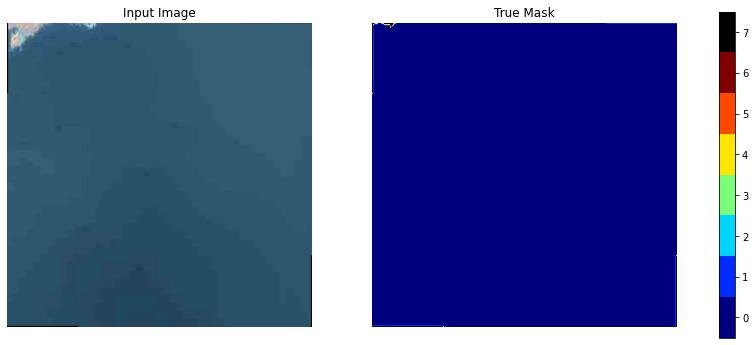

In [15]:
def display(display_list):
    fig, axs = plt.subplots(nrows=1, ncols = len(display_list), figsize=(15, 6))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        axs[i].set_title(title[i])
        if i==0:
            axs[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            msk = axs[i].imshow(display_list[i], cmap = cmap, vmin=0, vmax=n_colors-1)
        axs[i].axis('off')
        
    #plot colorbar
    cbar = fig.colorbar(msk, ax=axs, location='right')
    tick_locs = (np.arange(n_colors) + 0.5)*(n_colors-1)/n_colors#new tick locations so they are in the middle of the colorbar
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_colors))
    plt.show()

for image, mask in ds_train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Define Model

This model is an adapted version U-NET from the Dstl Satellite Imagery Feature Detection Kaggle competition. That competition also aimed to classify pixels in satelite images, so this model architucture might be a good fit here too. https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras

In [28]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras import Model
def get_unet():
    inputs = Input(shape=[IMG_SIZE[0], IMG_SIZE[1], 3])
    conv1 = Conv2D(32, 3, 1, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, 1, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop1)
    conv2 = Conv2D(64, 3, 1, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(128, 3, 1, activation='relu', padding='same')(drop2)
    conv3 = Conv2D(128, 3, 1, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(256, 3, 1, activation='relu', padding='same')(drop3)
    conv4 = Conv2D(256, 3, 1, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(512, 3, 1, activation='relu', padding='same')(drop4)
    conv5 = Conv2D(512, 3, 1, activation='relu', padding='same')(conv5)

    up6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([up6, conv4], axis=3)
    drop6 = Dropout(0.5)(merge6)
    conv6 = Conv2D(256, 3, 1, activation='relu', padding='same')(drop6)
    conv6 = Conv2D(256, 3, 1, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([up7, conv3], axis=3)
    drop7 = Dropout(0.5)(merge7)
    conv7 = Conv2D(128, 3, 1, activation='relu', padding='same')(drop7)
    conv7 = Conv2D(128, 3, 1, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([up8, conv2], axis=3)
    drop8 = Dropout(0.5)(merge8)
    conv8 = Conv2D(64, 3, 1, activation='relu', padding='same')(drop8)
    conv8 = Conv2D(64, 3, 1, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([up9, conv1], axis=3)
    drop9 = Dropout(0.5)(merge9)
    conv9 = Conv2D(32, 3, 1, activation='relu', padding='same')(drop9)
    conv9 = Conv2D(32, 3, 1, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_colors, 1, 1, activation='softmax')(conv9) #softmax converts the output to a list of probabilities that must sum to 1

    model = Model(inputs=inputs, outputs=conv10)
    return model

model = get_unet() 
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Model

In [29]:
#function to generate a mask from the model predictions
def create_mask(pred_mask, ele=0):
    pred_mask = tf.argmax(pred_mask, axis=-1)#use the highest probability class as the prediction
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[ele]

#helper functions to plot image, mask, and predicted mask while training
def show_predictions(dataset=None, num=1, ele=0):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[ele], mask[ele], create_mask(pred_mask, ele)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

#function to display loss during training
def plot_loss_acc(loss, val_loss, epoch):#, acc, val_acc, epoch):
    
    epochs = range(epoch+1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

    ax.plot(epochs, loss, 'r', label='Training loss')
    ax.plot(epochs, val_loss, 'bo', label='Validation loss')
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss Value')
    ax.legend()
    plt.show()
    
#callback to clear output and show predictions
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.loss = []
        self.val_loss = []
    
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        
        show_predictions()
        plot_loss_acc(self.loss, self.val_loss, epoch)
        
#callback to reduce learning rate when loss plateaus
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, verbose=1,)

#Define IoU metric (by stack overflow user HuckleberryFinn)
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Create a callback that saves the model's weights
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

In [30]:
#train model
model=get_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['sparse_categorical_accuracy', UpdatedMeanIoU(num_classes=n_colors)])

EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback(), lr_callback, cp_callback])

Epoch 1/100
 2/70 [..............................] - ETA: 4:13:17 - loss: 2.0513 - sparse_categorical_accuracy: 0.1909 - updated_mean_io_u: 0.0377

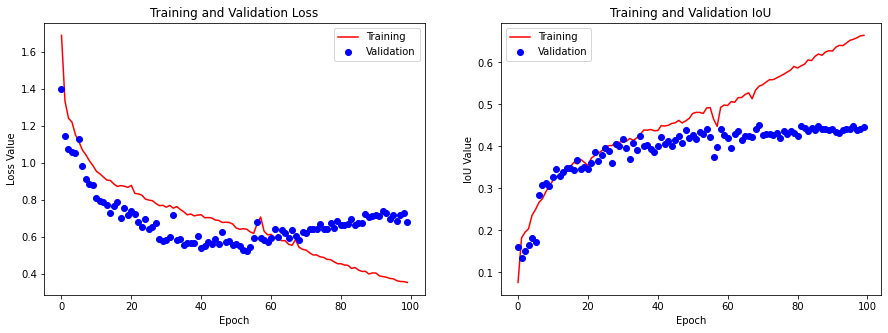

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

ax[0].plot(epochs, loss, 'r', label='Training')
ax[0].plot(epochs, val_loss, 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

IoU_key = list(model_history.history.keys())[2]
acc = model_history.history[IoU_key]
val_acc = model_history.history['val_'+IoU_key]

ax[1].plot(epochs, acc, 'r', label='Training')
ax[1].plot(epochs, val_acc, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.show()

In [27]:
#load weights for checkpoint 51
# print(os.listdir(checkpoint_dir))
model.load_weights(checkpoint_dir + '/cp-0051.ckpt')
scores = model.evaluate(val_dataset, verbose=0)
print('Final Model Validation Scores')
print('Loss: {:.3f}'.format(scores[0]))
print('Accuracy: {:.3f}'.format(scores[1]))
print('IoU: {:.3f}'.format(scores[2]))

Final Model Validation Scores
Loss: 0.502
Accuracy: 0.833
IoU: 0.441


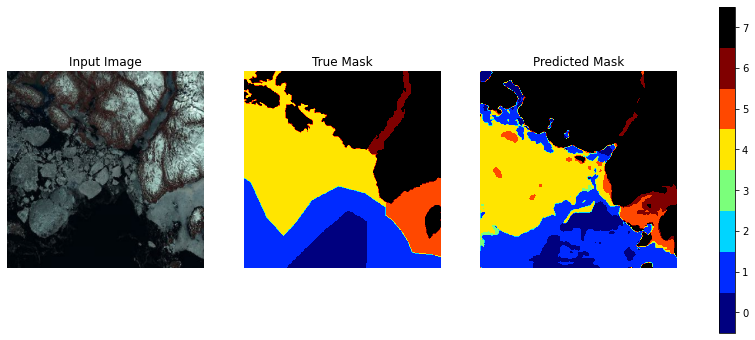

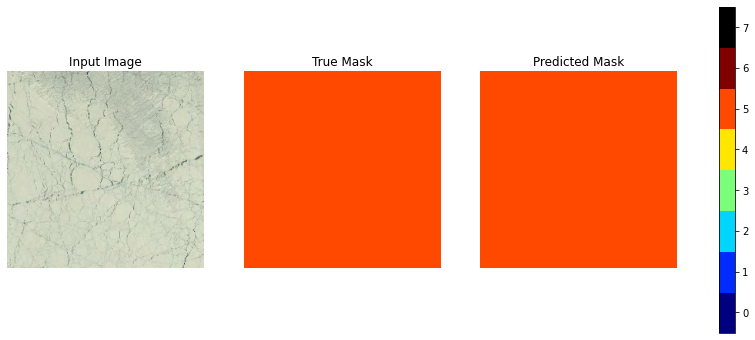

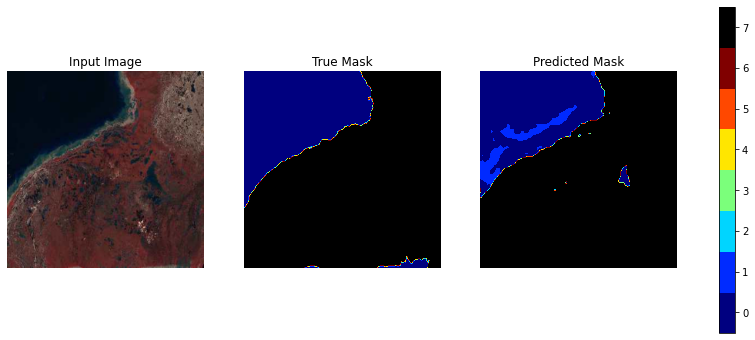

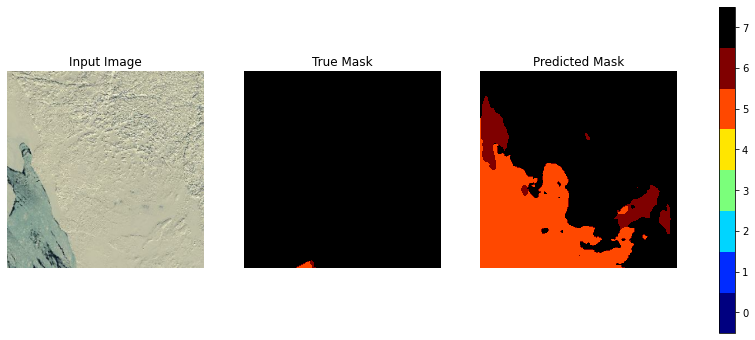

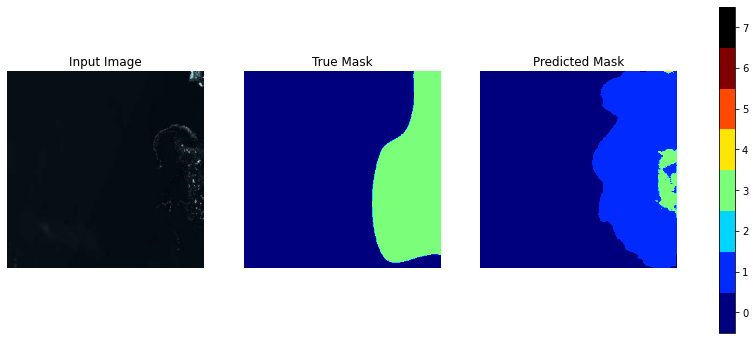

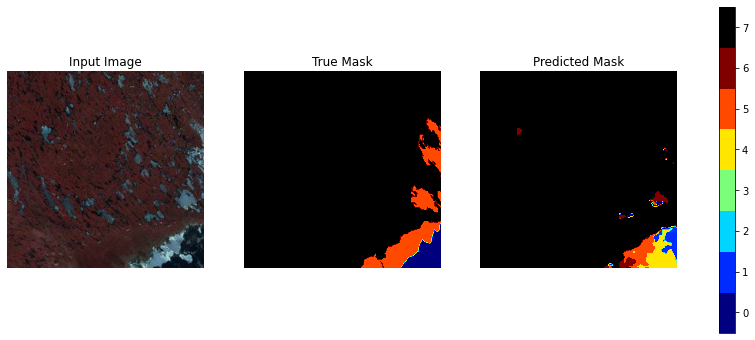

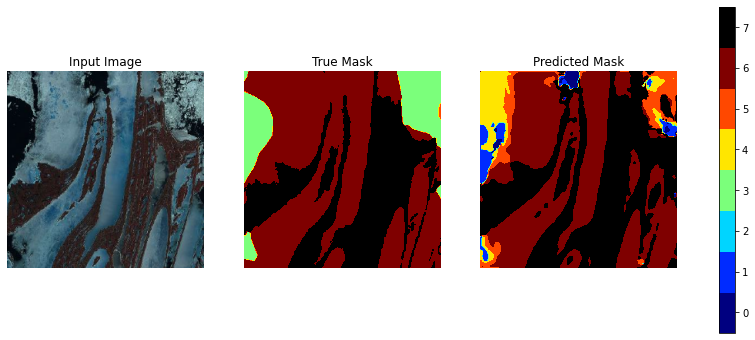

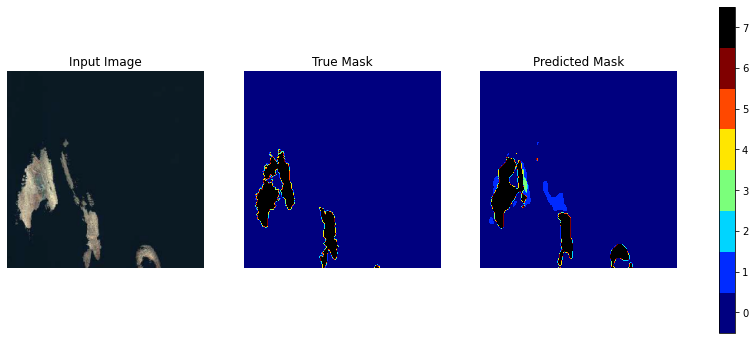

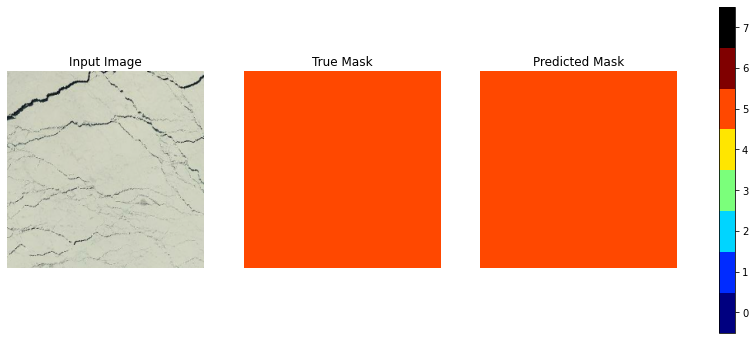

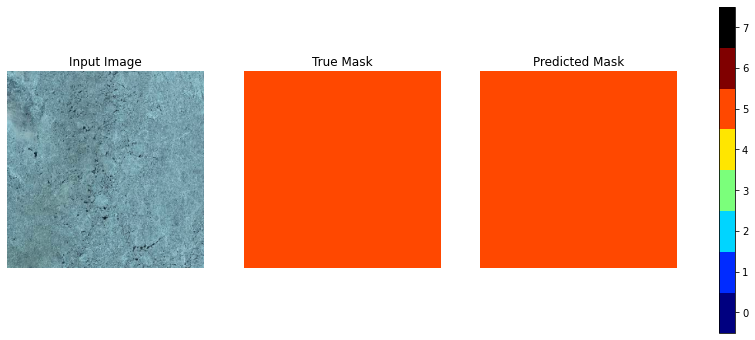

In [28]:
show_predictions(val_dataset, num=10, ele=3)

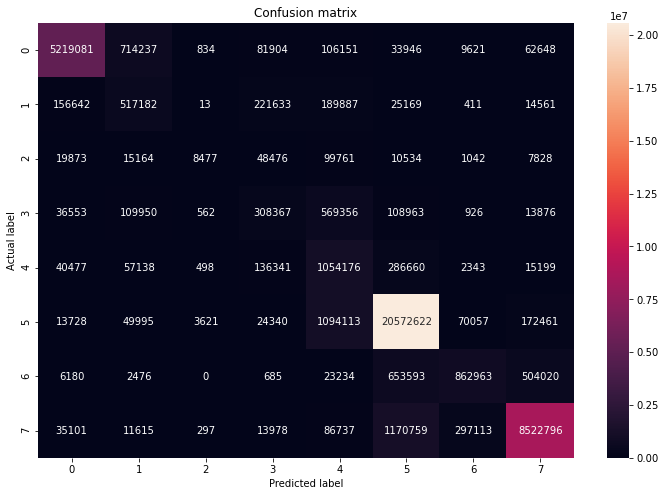

In [29]:
#plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_cm(model, val_ds):
    cm = np.zeros((8,8))
    for img_batch, mask_batch in val_dataset:
        y_pred = []
        y_true = []
        pred_batch = model.predict(img_batch)
        pred_batch = tf.argmax(pred_batch, axis=-1)#take the highest probability as the prediction for each pixel
        for n, pred in enumerate(pred_batch):
            pred = np.array(pred).flatten() #flattened array of predicted pixels for each image
            mask = np.array(mask_batch[n, ...]).flatten() #flattened array of mask pixels for the image
            y_pred.extend(pred)
            y_true.extend(mask)
        cm = cm + confusion_matrix(y_true, y_pred)
    return cm

cm = get_cm(model, val_dataset)
plt.figure(figsize=(12,8))
sns.heatmap(cm.astype(int), annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()